This notebook contains a Keras based CNN aimed at classifying the different fish categories

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras import models, layers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [3]:
#get data and import it using pathlib
root_path = Path("../input/a-large-scale-fish-dataset/Fish_Dataset")
sub_paths = root_path.glob(r'**/*.png')
#converting to list, will deal with generator later
sub_paths = list(sub_paths)

#creating temporary list to handle generator
data = []
for i in range(len(sub_paths)):
    #get the 2nd from last directory name
    label = os.path.split(os.path.split(sub_paths[i])[0])[1]
    data.append([str(sub_paths[i]), label])
#print(*data[1:5], sep="\n")
    
#Appending data to dataframe
df = pd.DataFrame(data, columns=['path', 'label'])
#Removing ground truths 
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)

In [4]:
pd.set_option('display.max_colwidth', None)
df.head(5)

,path,label
0,../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00704.png,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00562.png,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00237.png,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00406.png,Hourse Mackerel


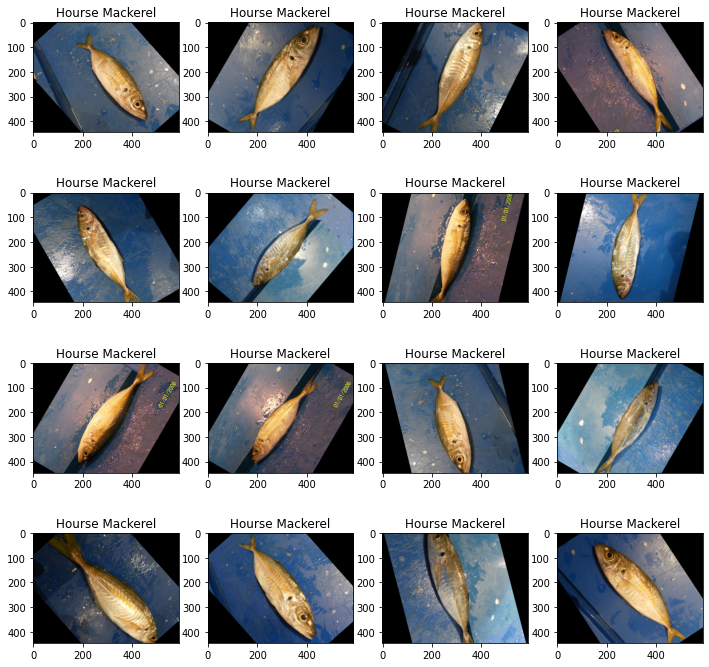

In [5]:
#plot the first 16 images to verify correctness
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for index, ax in enumerate(axes.flat):
    #supress output that isn't related to images by using _
    _ = ax.imshow(plt.imread(df.path[index]))
    _ = ax.set_title(df.label[index])

In [ ]:
#Verify the correct amount of values exist
df.describe()
df.isnull().any()
df['label'].value_counts()

In [6]:
#Splitting into training, validation, and testing data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2, shuffle=True)
train_df.count()
test_df.count()

path     7200
label    7200
dtype: int64

path     1800
label    1800
dtype: int64

In [7]:
#Importing images using image data preprocessing provided from keras
train_generator = ImageDataGenerator(validation_split=0.2)
test_generator = ImageDataGenerator()

train_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "training"
)

val_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "validation"
)

test_imgs = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [42]:
#setup model
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

#flattening and softmax to show probability for each class

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [43]:
#train model
eps = 8
history = model.fit(train_imgs, epochs=eps, batch_size=32, validation_data=val_imgs)

Epoch 1/8
180/180 [==============================] - 76s 418ms/step - loss: 125.4215 - accuracy: 0.5515 - val_loss: 0.1488 - val_accuracy: 0.9472
Epoch 2/8
180/180 [==============================] - 74s 413ms/step - loss: 1.7595 - accuracy: 0.9125 - val_loss: 0.1745 - val_accuracy: 0.9493
Epoch 3/8
180/180 [==============================] - 75s 415ms/step - loss: 0.4209 - accuracy: 0.9474 - val_loss: 0.1795 - val_accuracy: 0.9708
Epoch 4/8
180/180 [==============================] - 74s 414ms/step - loss: 0.2704 - accuracy: 0.9634 - val_loss: 0.4751 - val_accuracy: 0.9354
Epoch 5/8
180/180 [==============================] - 75s 416ms/step - loss: 2.4990 - accuracy: 0.9588 - val_loss: 0.0918 - val_accuracy: 0.9826
Epoch 6/8
180/180 [==============================] - 75s 416ms/step - loss: 0.4319 - accuracy: 0.9732 - val_loss: 0.0859 - val_accuracy: 0.9868
Epoch 7/8
180/180 [==============================] - 75s 419ms/step - loss: 0.5915 - accuracy: 0.9840 - val_loss: 0.6811 - val_accurac

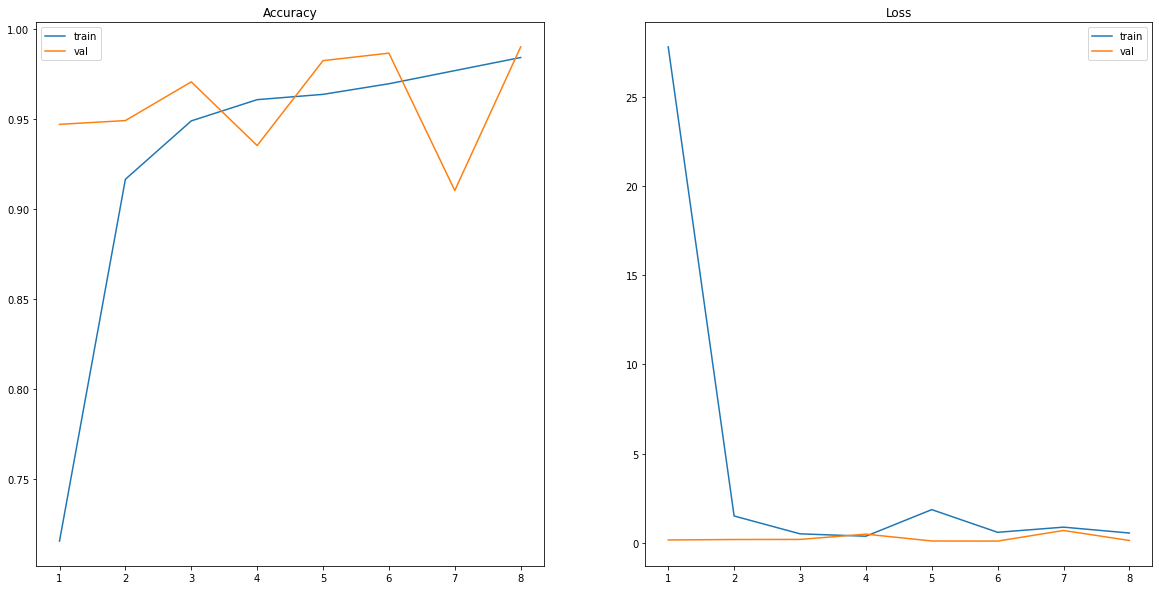

In [44]:
#plot graphs to check model efficacy
history_dic = history.history
train_acc = history_dic['accuracy']
train_loss = history_dic['loss']
val_acc = history_dic['val_accuracy']
val_loss = history_dic['val_loss']
epochs = range(1, len(train_acc) + 1)

figure, axis = plt.subplots(1, 2, figsize=(20, 10))
axis[0].plot(epochs, train_acc, label="train")
axis[0].plot(epochs, val_acc, label="val")
axis[0].set_title('Accuracy')
axis[0].legend()
axis[1].plot(epochs, train_loss, label="train")
axis[1].plot(epochs, val_loss, label="val")
axis[1].set_title('Loss')
axis[1].legend()

plt.show(); #suppressing output 